In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import *
from sklearn.linear_model import *
import sklearn.metrics as metrics
from sklearn.datasets import fetch_openml
from sklearn.model_selection import *
from scipy import ndimage

import warnings
warnings.simplefilter("ignore")

# Problem 7.2

In [2]:
data = np.loadtxt("4class_data.csv", delimiter=',')
x, y = data[:-1, :], data[-1:, :].flatten()

print(x.shape)
print(y.shape)

(2, 40)
(40,)


In [3]:
OvA = OneVsRestClassifier(Perceptron(max_iter=100000, early_stopping=False,\
                                    fit_intercept=True, warm_start=False, penalty='l1',\
                                    alpha=0.0005))
OvA.fit(x.T, y)

OneVsRestClassifier(estimator=Perceptron(alpha=0.0005, class_weight=None,
                                         early_stopping=False, eta0=1.0,
                                         fit_intercept=True, max_iter=100000,
                                         n_iter_no_change=5, n_jobs=None,
                                         penalty='l1', random_state=0,
                                         shuffle=True, tol=0.001,
                                         validation_fraction=0.1, verbose=0,
                                         warm_start=False),
                    n_jobs=None)

In [4]:
OvA_pred = OvA.predict(x.T)

In [5]:
mat = metrics.confusion_matrix(y.flatten(), OvA_pred)

In [6]:
mat

array([[9, 1, 0, 0],
       [1, 8, 0, 1],
       [1, 1, 5, 3],
       [0, 1, 0, 9]], dtype=int64)

In [7]:
print("Number of classifications: %s" % str(np.sum(mat) - np.sum(np.diag(mat))))

Number of classifications: 9


# Problem 7.3

In [8]:
data = np.loadtxt("3class_data.csv", delimiter=',')
x, y = data[:-1, :], data[-1:, :].flatten()

print(x.shape)
print(y.shape)

(2, 30)
(30,)


In [9]:
MC = Perceptron(max_iter=100000, early_stopping=False,\
                                    fit_intercept=True, warm_start=False, penalty='l1',\
                                    alpha=0.0005)

In [10]:
MC.fit(x.T, y)

Perceptron(alpha=0.0005, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=100000, n_iter_no_change=5, n_jobs=None,
           penalty='l1', random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
pred = MC.predict(x.T)

In [12]:
mat = metrics.confusion_matrix(y, pred)

In [13]:
mat

array([[10,  0,  0],
       [ 0, 10,  0],
       [ 0,  0, 10]], dtype=int64)

In [14]:
print("Number of classifications: %s" % str(np.sum(mat) - np.sum(np.diag(mat))))

Number of classifications: 0


# Problem 9.2

In [15]:
x, y = fetch_openml('mnist_784', version=1, return_X_y = True)
y = y.astype(int)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=50000)

## Pixel-based training

In [17]:
#Arrays to store test and training histograms
pixel_hists_train = np.zeros((X_train.shape[0], 256))
pixel_hists_test  = np.zeros((X_test.shape[0], 256))

#Training
for i in range(pixel_hists_train.shape[0]):
    count = np.histogram(X_train[i], bins=256, range=[0, 255])[0]
    pixel_hists_train[i, :] = 1.0*count

#Test
for i in range(pixel_hists_test.shape[0]):
    count = np.histogram(X_test[i], bins=256, range=[0, 255])[0]
    pixel_hists_test[i, :] = 1.0*count

In [18]:
#Arrays to store score and cost functions
pix_score = np.array([])
pix_cost  = np.array([])

#Run through 1 to 20 steps
for j in range(1, 21):
    softmax = SGDClassifier(loss = 'log', penalty='l1', alpha=0.01, max_iter=j, \
                            early_stopping=False, warm_start=True)
    
    #Fit and predict
    softmax.fit(pixel_hists_train, y_train)
    y_pred = softmax.predict_proba(pixel_hists_test)
    
    #Calculate a score (% right) and cost function; save
    pix_score = np.append(pix_score, softmax.score(pixel_hists_test, y_test))
    pix_cost  = np.append(pix_cost, metrics.log_loss(y_test, y_pred, normalize=True))

## Edge training

In [19]:
#Arrays to store test and training histograms
edge_hists_train = np.zeros((X_train.shape[0], 8))
edge_hists_test = np.zeros((X_test.shape[0], 8))

#Training
for i in range(edge_hists_train.shape[0]):
    reshape = X_train[i].reshape((28, 28))
    
    #Calculate Gaussian derivatives to find edges in x and y directions
    dIdx = ndimage.filters.gaussian_filter(reshape, [1, 1], order=[0,1], mode='nearest')
    dIdy = ndimage.filters.gaussian_filter(reshape, [1, 1], order=[1,0], mode='nearest')
    
    #Determine the angle of the edge
    angle = np.arctan(dIdy / dIdx)
    
    #Make histogram
    count = np.histogram(angle, bins=8, range=[-np.pi/2, np.pi/2])[0]
    edge_hists_train[i, :] = 1.0 * count
    
#Test
for i in range(edge_hists_test.shape[0]):
    reshape = X_test[i].reshape((28, 28))
    
    dIdx = ndimage.filters.gaussian_filter(reshape, [1, 1], order=[0,1], mode='nearest')
    dIdy = ndimage.filters.gaussian_filter(reshape, [1, 1], order=[1,0], mode='nearest')
    
    angle = np.arctan(dIdy / dIdx)
    
    count = np.histogram(angle, bins=8, range=[-np.pi/2, np.pi/2])[0]
    edge_hists_test[i, :] = 1.0 * count

In [20]:
edge_score = np.array([])
edge_cost  = np.array([])

for j in range(1, 21):
    softmax = SGDClassifier(loss = 'log', penalty='l1', alpha=0.01, max_iter=j, \
                            early_stopping=False, warm_start=True)
    
    softmax.fit(edge_hists_train, y_train)
    y_pred = softmax.predict_proba(edge_hists_test)
    
    edge_score = np.append(edge_score, softmax.score(edge_hists_test, y_test))
    edge_cost  = np.append(edge_cost,  metrics.log_loss(y_test, y_pred, normalize=True))

(0, 20)

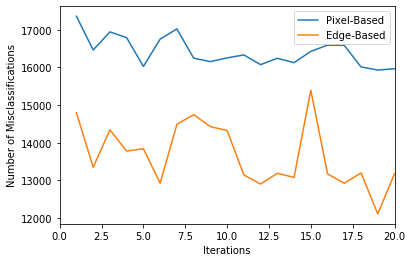

In [21]:
plt.plot(list(range(1, 21)), (1.0 - pix_score) * X_test.shape[0], label="Pixel-Based")
plt.plot(list(range(1, 21)), (1.0 - edge_score) * X_test.shape[0], label="Edge-Based")
plt.xlabel("Iterations")
plt.ylabel("Number of Misclassifications")
plt.legend()
plt.xlim(0, 20)

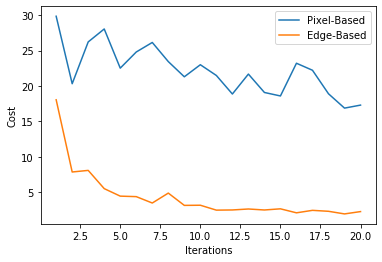

In [22]:
plt.plot(list(range(1, 21)), pix_cost, label="Pixel-Based")
plt.plot(list(range(1, 21)), edge_cost, label="Edge-Based")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.legend()